In [11]:
from docplex.cp.model import *
import os
from pathlib import Path
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mplcursors
from functools import reduce
import matplotlib.colors as mcolors


In [12]:

class InputProcessor:
    def __init__(self, data_folder, flows_csv, NB_Queues, NB_Switches, LinkBW, Switch_Processing_Delay, Propagation_Delay, queue_mapping=None):
        self.data_folder = data_folder
        self.flows_csv = flows_csv
        self.NB_Queues = NB_Queues
        self.NB_Switches = NB_Switches
        self.LinkBW = LinkBW
        self.Switch_Processing_Delay = Switch_Processing_Delay
        self.Propagation_Delay = Propagation_Delay
        self.queue_mapping = queue_mapping or {
            1: {i: 0 for i in range(8)},  # All PCP values map to queue 0 when there is 1 queue
            2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1},  # Mapping for 2 queues
            3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 2, 7: 2},  # Mapping for 3 queues
            4: {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 2, 6: 3, 7: 3},  # Mapping for 4 queues
            5: {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 3, 6: 3, 7: 4},  # Mapping for 5 queues
            6: {0: 0, 1: 0, 2: 1, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5},  # Mapping for 6 queues
            7: {0: 0, 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6},  # Mapping for 7 queues
            8: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}   # Mapping for 8 queues
        }
        
    def get_flow_durations(self):
        # Read the flows.csv file
        flows_df = pd.read_csv(self.data_folder / self.flows_csv)
        
        NB_Queues_Switches = self.NB_Queues * self.NB_Switches
        
        # Calculate the number of flows as the count of the 'Name' column
        NB_FLOWS = flows_df['Name'].count()
        
        # Calculate the transmission delays
        flows_df['Transmission_Delay'] = ((flows_df['Size'] * 8) / self.LinkBW) * 1e6  # automatic microsecond conversion
        
        # Calculate the total delays
        flows_df['Total_Delay'] = flows_df['Transmission_Delay'] + self.Switch_Processing_Delay * 1e6 + self.Propagation_Delay
        display(flows_df)
        
        # Prepare the flow durations data structure
        FLOW_DURATIONS = []
        PeriodDeadline = []  # Initialize the PeriodDeadline list
        Periods = []  # List to store periods of all flows for calculating LCM

        for _, row in flows_df.iterrows():
            Total_Delay = float(row['Total_Delay'])
            PCP = int(row['PCP'])
            
            # Initialize flow duration with zeros
            flow_duration = [0] * NB_Queues_Switches
            
            # Determine the queue index based on the provided or default mapping
            if self.NB_Queues in self.queue_mapping:
                queue_index = self.queue_mapping[self.NB_Queues].get(PCP, 0)  # default to 0 if PCP is not in the mapping
            else:
                raise ValueError(f"Queue mapping for {self.NB_Queues} queues is not defined.")

            # Assign the total delay to the appropriate queue index
            for switch in range(self.NB_Switches):
                index = queue_index + switch * self.NB_Queues
                flow_duration[index] = Total_Delay
            
            FLOW_DURATIONS.append(flow_duration)
            
            # Append Period, Deadline, and PCP to the PeriodDeadline list
            Period = int(row['Period'])
            Deadline = int(row['Deadline'])
            PeriodDeadline.append([Period, Deadline, PCP])
            
            # Add the period to the Periods list
            Periods.append(Period)
        
        # Calculate the GateCycleDuration as the LCM of all periods
        GateCycleDuration = reduce(math.lcm, Periods)
        
        return flows_df, NB_FLOWS, NB_Queues_Switches, FLOW_DURATIONS, PeriodDeadline, GateCycleDuration



In [17]:


class SchedulingModel:
    def __init__(self, flows_df, FLOW_DURATIONS, PeriodDeadline, GateCycleDuration, NB_Queues, NB_Switches):
        self.flows_df = flows_df
        self.FLOW_DURATIONS = FLOW_DURATIONS
        self.PeriodDeadline = PeriodDeadline
        self.GateCycleDuration = GateCycleDuration
        self.NB_Queues = NB_Queues
        self.NB_Switches = NB_Switches
        self.NB_FLOWS = len(flows_df)
        self.mdl = CpoModel()

    def create_interval_vars(self):
        # Interval variables for clients
        self.interval_vars_client = [
            self.mdl.interval_var(
                size=math.ceil(row['Total_Delay']),
                name='{}-{}'.format(row['Name'], row['Source'])
            )
            for _, row in self.flows_df.iterrows()
        ]
        
        # Interval variables for switches
        self.flow_operations = [
            [
                self.mdl.interval_var(
                    size=math.ceil(self.FLOW_DURATIONS[j][m]),
                    start=(0, math.ceil(self.PeriodDeadline[j][0] - self.FLOW_DURATIONS[j][m])),
                    end=(math.ceil(self.FLOW_DURATIONS[j][m]), self.GateCycleDuration),
                    name='F{}-M{}'.format(j, m)
                )
                for m in range(self.NB_Queues * self.NB_Switches) if self.FLOW_DURATIONS[j][m] != 0
            ]
            for j in range(self.NB_FLOWS)
        ]
        
        # Sequence variables for same switch queues
        self.SameSwitchQueue_Sequences = [
            self.mdl.sequence_var(
                [self.flow_operations[j][m] for j in range(self.NB_FLOWS) if len(self.flow_operations[j]) > m],
                name=f'Seq_{m}'
            )
            for m in range(self.NB_Queues)
        ]

        # Sequence variable for link sequence
        self.Link_Seq = self.mdl.sequence_var(self.interval_vars_client, name='Link_Seq')

    def add_constraint1(self):
        for i in range(self.NB_FLOWS):
            if len(self.flow_operations[i]) > 0:
                self.mdl.add(end_before_start(self.interval_vars_client[i], self.flow_operations[i][0]))

    def add_constraint2(self):
        for j in range(self.NB_FLOWS):
            for m in range(1, len(self.flow_operations[j])):
                self.mdl.add(end_before_start(self.flow_operations[j][m-1], self.flow_operations[j][m]))

    def add_constraint3(self):
        self.mdl.add(no_overlap(self.Link_Seq))
        for seq in self.SameSwitchQueue_Sequences:
            self.mdl.add(no_overlap(seq))

    def add_constraint4(self):
        for j in range(self.NB_FLOWS):
            self.mdl.add(end_of(self.flow_operations[j][1]) - start_of(self.flow_operations[j][0]) <= self.PeriodDeadline[j][1])

    def minimize_end_to_end_delay(self):
        self.mdl.add(
            self.mdl.minimize(
                self.mdl.sum(self.PeriodDeadline[j][2] * self.mdl.max([0, end_of(self.flow_operations[j][1]) - start_of(self.flow_operations[j][0])]) for j in range(self.NB_FLOWS))
            )
        )

    def export_model(self, filename="chain.cpo"):
        self.mdl.export_as_cpo(filename)

    def solve(self, fail_limit=10000, time_limit=100, log_output=True):
        print('Solving model...')
        return self.mdl.solve(FailLimit=fail_limit, TimeLimit=time_limit, log_output=log_output)





In [14]:
class ResultProcessor:
    def __init__(self, scheduling_model):
        self.scheduling_model = scheduling_model

    def process_results(self, res):
        # Collect results from interval_vars_client
        interval_vars_client_results = [res.get_var_solution(iv) for iv in self.scheduling_model.interval_vars_client]
        interval_vars_client_names = [iv.get_name() for iv in self.scheduling_model.interval_vars_client]

        # Collect results from flow_operations
        flow_operations_results = []
        for j in range(self.scheduling_model.NB_FLOWS):
            for m in range(len(self.scheduling_model.flow_operations[j])):
                flow_operations_results.append(res.get_var_solution(self.scheduling_model.flow_operations[j][m]))

        # Initialize lists to store schedule information
        names = []
        starts = []
        ends = []
        durations = []

        # Populate lists with results from interval_vars_client
        for i, iv in enumerate(self.scheduling_model.interval_vars_client):
            iv_result = res.get_var_solution(iv)
            if iv_result:
                names.append(iv.get_name())
                starts.append(iv_result.get_start())
                ends.append(iv_result.get_end())
                durations.append(iv_result.get_size())

        # Populate lists with results from flow_operations
        for j in range(self.scheduling_model.NB_FLOWS):
            for iv in self.scheduling_model.flow_operations[j]:
                iv_result = res.get_var_solution(iv)
                if iv_result:
                    names.append(iv.get_name())
                    starts.append(iv_result.get_start())
                    ends.append(iv_result.get_end())
                    durations.append(iv_result.get_size())

        # Create a pandas DataFrame with the schedule information
        schedule = pd.DataFrame({
            'Name': names,
            'Start': starts,
            'End': ends,
            'Duration': durations
        })

        # Sort the schedule DataFrame by 'Name'
        schedule.sort_values(by=['Name'], inplace=True)
        schedule.reset_index(drop=True, inplace=True)

        # Scale down the schedule times by dividing by 10
        #schedule['Start'] = schedule['Start'] / 10
        #schedule['End'] = schedule['End'] / 10
        #schedule['Duration'] = schedule['Duration'] / 10

# Map machine names dynamically
        schedule['Flow'] = schedule['Name'].apply(lambda x: x.split('-')[0])
        schedule['Machine'] = schedule['Name'].apply(self.map_machine_name)

        # Print the schedule DataFrame

        return schedule
    def map_machine_name(self, name):
        _, machine = name.split('-')
        if machine.startswith('M'):
            m = int(machine[1:])  # Extract the numeric part after 'M'
            switch = m // self.scheduling_model.NB_Queues
            queue = m % self.scheduling_model.NB_Queues
            return f'S{switch}Q{queue}'
        return machine

    def assign_machines(self, schedule):
        # Map machine names dynamically
        schedule['Flow'] = schedule['Name'].apply(lambda x: x.split('-')[0])
        schedule['Machine'] = schedule['Name'].apply(self.map_machine_name)

        return schedule
    
    def assign_colors(self, schedule):
        unique_flows = schedule['Flow'].unique()
        colors = list(mcolors.TABLEAU_COLORS.values())
        color_map = {flow: colors[i % len(colors)] for i, flow in enumerate(unique_flows)}
        schedule['color'] = schedule['Flow'].map(color_map)
        return schedule

    def plot_gantt_chart(self, schedule, gate_cycle):
        def gantt(y1, string):  # gantt(schedule.Machine, 'Machine')
            name1 = y1
            fig, ax = plt.subplots(1, figsize=(16, 6))
            ax2 = ax.twinx()
            ax.set_axisbelow(True)
            # grid
            ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.8, which='both')
            # ticks
            xticks = np.arange(start=0, stop=gate_cycle, step=10)
            ax.set_xticks(xticks)
            ax.barh(name1, schedule.Duration, left=schedule.Start, color=schedule.color, alpha=1)
            ax.invert_yaxis()
            plt.savefig("gantts_{}.png".format(string))
            plt.show()

        gantt(schedule.Machine, 'Machine')

In [18]:


class GCLProcessor:
    def __init__(self, df, GateCycleDuration):
        self.df = df
        self.GateCycleDuration = GateCycleDuration

    def compute_lcm(self, periods):
        return reduce(math.lcm, periods)

    def ILP_to_GCL(self):
        output = []

        # For each machine, we calculate the relevant values
        for machine in self.df['Machine'].unique():
            machine_df = self.df[self.df['Machine'] == machine].sort_values('Start')
            durations = []
            offset = 0

            # Iterate through flows associated with this machine
            for i in range(len(machine_df)):
                flow = machine_df.iloc[i]
                durations.append(f"{flow['Duration']}us")
                if i != len(machine_df) - 1:
                    next_start = machine_df.iloc[i+1]['Start']
                    durations.append(f"{next_start - flow['End']}us")
                else:
                    durations.append(f"{self.GateCycleDuration - sum([float(d.split('us')[0]) for d in durations])}us")

            offset = self.GateCycleDuration - machine_df.iloc[0]['Start']

            if 'CL' in machine:  # If it's a client
                client_index = int(machine[-1])  # Extract the client index
                for i in range(len(machine_df)):
                    flow_start_time = machine_df.iloc[i]['Start']
                    output.append(f'*.client{client_index}.app[{i}].source.initialProductionOffset= {flow_start_time}us')

            elif 'S' in machine:  # If it's a switch
                switch_index = int(machine[machine.index('S') + 1:machine.index('Q')]) + 1
                queue_index = machine[machine.index('Q') + 1]
                output.append(f'*.switch{switch_index}.eth[2].macLayer.queue.transmissionGate[{queue_index}].offset = {offset}us')
                output.append(f'*.switch{switch_index}.eth[2].macLayer.queue.transmissionGate[{queue_index}].durations = [{", ".join(durations)}]')

        # Return the .ini file
        ini_file = '\n'.join(output)
        return ini_file



###disclaimer need to update the switch ethernet address eth[] according to scenario. Partially job done. 

,Name,PCP,Size,Period,Deadline,Destination,Source,Transmission_Delay,Total_Delay
0,F0,1,1000,1000,500,CL3,CL1,80.0,85.6
1,F1,5,500,500,500,CL4,CL1,40.0,45.6
2,F2,1,1000,1000,500,CL3,CL2,80.0,85.6
3,F3,5,500,500,500,CL4,CL2,40.0,45.6


Solving model...
 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Minimization problem - 15 variables, 15 constraints
 ! Presolve      : 4 extractables eliminated
 ! FailLimit            = 10000
 ! TimeLimit            = 100
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 43.0 (before), 43.0 (after)
 !  . Memory usage      : 441.9 kB (before), 441.9 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         15                 -
 + New bound is 0
 ! Using iterative diving.
 ! Using temporal relaxation.
                        0         15    1            -
 + New bound is 1264
 *          1464       29  0.03s        1      (gap is 13.66%)
 *          1264       53  0.03s        1      (gap is 0.00%)
 ! -----------------------------------

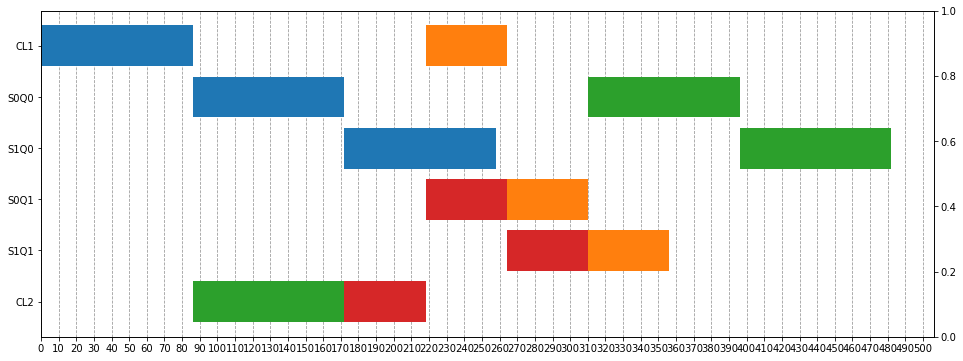

*.client1.app[0].source.initialProductionOffset= 0us
*.client1.app[1].source.initialProductionOffset= 218us
*.switch1.eth[2].macLayer.queue.transmissionGate[0].offset = 914us
*.switch1.eth[2].macLayer.queue.transmissionGate[0].durations = [86us, 138us, 86us, 690.0us]
*.switch2.eth[2].macLayer.queue.transmissionGate[0].offset = 828us
*.switch2.eth[2].macLayer.queue.transmissionGate[0].durations = [86us, 138us, 86us, 690.0us]
*.switch1.eth[2].macLayer.queue.transmissionGate[1].offset = 782us
*.switch1.eth[2].macLayer.queue.transmissionGate[1].durations = [46us, 0us, 46us, 908.0us]
*.switch2.eth[2].macLayer.queue.transmissionGate[1].offset = 736us
*.switch2.eth[2].macLayer.queue.transmissionGate[1].durations = [46us, 0us, 46us, 908.0us]
*.client2.app[0].source.initialProductionOffset= 86us
*.client2.app[1].source.initialProductionOffset= 172us


In [19]:

NB_Queues = 2
NB_Switches = 2
LinkBW=100 * 1e6
Switch_Processing_Delay=5.6*1e-6
Propagation_Delay=0
queue_mapping=None
# Processing the input
data_folder = Path("C:/Users/Syed/Documents/sched/data/")  # Update this path as necessary
input_processor = InputProcessor(data_folder, "flows.csv", NB_Queues, NB_Switches, LinkBW, Switch_Processing_Delay, Propagation_Delay, queue_mapping)
flows_df, NB_FLOWS, NB_Queues_Switches, FLOW_DURATIONS, PeriodDeadline, GateCycleDuration = input_processor.get_flow_durations()


# Create and configure the scheduling model
scheduling_model = SchedulingModel(flows_df, FLOW_DURATIONS, PeriodDeadline, GateCycleDuration, NB_Queues, NB_Switches)
scheduling_model.create_interval_vars()
scheduling_model.add_constraint1()
scheduling_model.add_constraint2()
scheduling_model.add_constraint3()
scheduling_model.add_constraint4()
scheduling_model.minimize_end_to_end_delay()
scheduling_model.export_model()

# Solve the model
# Solve the model
result = scheduling_model.solve()

# Process the results using the ResultProcessor class
result_processor = ResultProcessor(scheduling_model)
schedule = result_processor.process_results(result)

# Assign machines to the schedule
schedule = result_processor.assign_machines(schedule)

# Print the final schedule with assigned machines
print(schedule)
schedule = result_processor.assign_colors(schedule)

# Plot the Gantt chart
result_processor.plot_gantt_chart(schedule, GateCycleDuration)

# Create ILPProcessor instance and generate GCL configuration
GCLProcessor = GCLProcessor(schedule, GateCycleDuration)
ini_file = GCLProcessor.ILP_to_GCL()

# Print the generated .ini file
print(ini_file)
